In [ ]:
import time
import copy
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, ConcatDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_dataloaders(batch_size=128, num_workers=2, split=0.5):
    # Load CIFAR-100 dataset
    initial_transforms = transforms.ToTensor()
    train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=initial_transforms)
    val_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=initial_transforms)

    # Combine train and test datasets
    full_dataset = ConcatDataset([train_dataset, val_dataset])

    # Split into new train and val sets
    train_size = int((1 - split) * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])

    # Data transformations for training and validation
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define transforms with the calculated mean and std
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    # Apply transforms to the respective sets
    train_set.dataset.transform = train_transforms
    val_set.dataset.transform = val_transforms

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Create DataLoaders
    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

    return dataloaders

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def save_softmax_scores(model, dataloader, device, output_path):
    model.eval()
    softmax = nn.Softmax(dim=1)
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            scores = softmax(outputs).cpu().numpy()
            all_scores.append(scores)
            all_labels.append(labels.numpy())

    all_scores = np.concatenate(all_scores, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    np.save(output_path + 'scores.npy', all_scores)
    np.save(output_path + 'labels.npy', all_labels)
    print(f"Softmax scores and labels saved to {output_path}scores.npy and {output_path}labels.npy")
    # print number of scores and labels
    print(f"Number of scores: {all_scores.shape}")
    print(f"Number of labels: {all_labels.shape}")

In [ ]:
def show_img(img, title=""):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
num_classes = 100
batch_size = 128
lr = 0.0001
num_epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
num_workers = 4
model_filename = 'best_cifar100_model'
output_path = './results/'

Using device: cuda


In [ ]:
dataloaders = get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer, num_epochs, device)

Epoch 1/30
----------
train Loss: 3.8491 Acc: 0.1542
val Loss: 2.7306 Acc: 0.3390

Epoch 2/30
----------
train Loss: 2.1271 Acc: 0.4573
val Loss: 1.9160 Acc: 0.4876

Epoch 3/30
----------
train Loss: 1.3544 Acc: 0.6260
val Loss: 1.7136 Acc: 0.5391

Epoch 4/30
----------
train Loss: 0.8947 Acc: 0.7564
val Loss: 1.7264 Acc: 0.5504

Epoch 5/30
----------
train Loss: 0.5940 Acc: 0.8438
val Loss: 1.7240 Acc: 0.5637

Epoch 6/30
----------
train Loss: 0.3896 Acc: 0.9029
val Loss: 1.7224 Acc: 0.5736

Epoch 7/30
----------
train Loss: 0.2532 Acc: 0.9419
val Loss: 1.7557 Acc: 0.5801

Epoch 8/30
----------
train Loss: 0.1775 Acc: 0.9610
val Loss: 1.8109 Acc: 0.5828

Epoch 9/30
----------
train Loss: 0.1281 Acc: 0.9738
val Loss: 1.8987 Acc: 0.5816

Epoch 10/30
----------
train Loss: 0.1135 Acc: 0.9754
val Loss: 1.9290 Acc: 0.5800

Epoch 11/30
----------
train Loss: 0.0983 Acc: 0.9789
val Loss: 1.9665 Acc: 0.5835

Epoch 12/30
----------
train Loss: 0.0886 Acc: 0.9801
val Loss: 2.0402 Acc: 0.5802

E

In [ ]:
os.makedirs(output_path, exist_ok=True)
torch.save(model.state_dict(), f'{output_path}{model_filename}.pth')
print(f'Model saved to {output_path}{model_filename}.pth')

# Save softmax scores for validation set
save_softmax_scores(model, dataloaders['val'], device, output_path)

Model saved to ./results/best_cifar100_model.pth
Softmax scores and labels saved to ./results_scores.npy and ./results_labels.npy


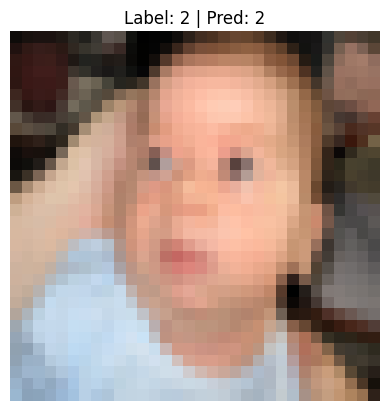

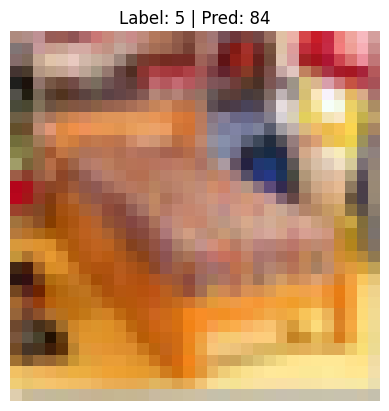

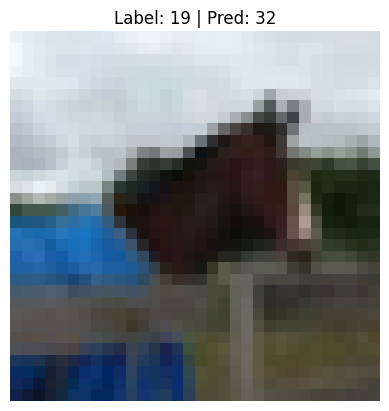

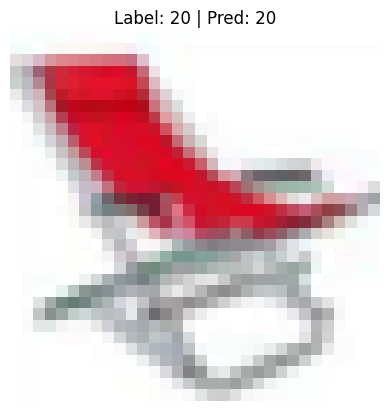

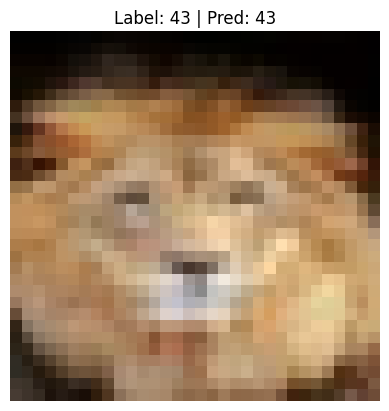

In [ ]:
# Visualize a few validation images with predictions
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(5):  # Show 5 images
            show_img(inputs[i].cpu(), title=f"Label: {labels[i]} | Pred: {preds[i].item()}")
        break